In [ ]:
name = "Ciro B Rosa"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Ciro B Rosa

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [ ]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


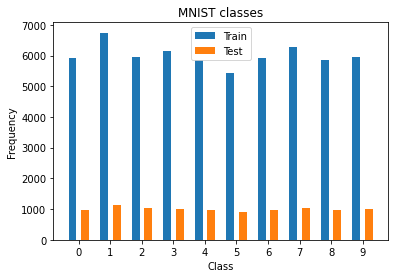

In [ ]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

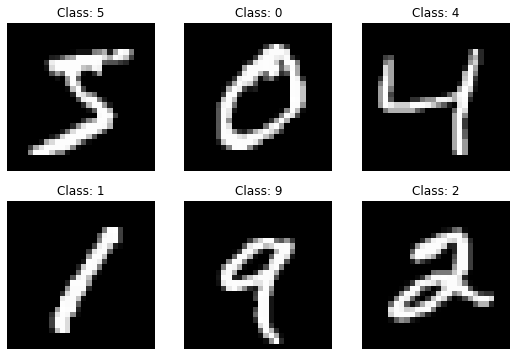

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [ ]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

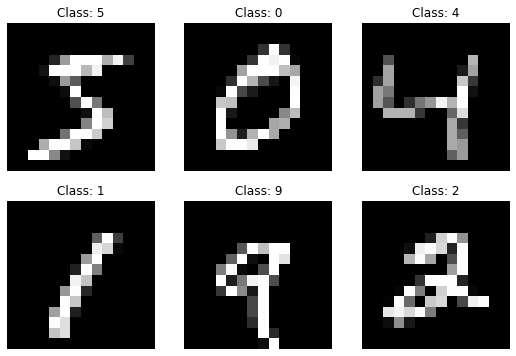

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [ ]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))


float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


**1. Dataset preparation**

A seguir, o dataset de treinamento do MNIST é particionado na proporção 70/30 e nomeado como Dtrain e Dval respectivamente. Sua estratificação em cada uma das 10 classes também é demonstrada.


Shape of X_Dtrain:  (42000, 196)
Shape of X_Dval:  (18000, 196)


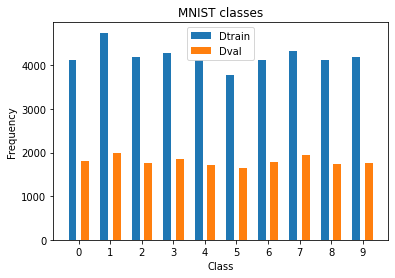

In [ ]:
from sklearn.model_selection import train_test_split

seed = 42   # fix seed to make results repeatable
X_Dtrain, X_Dval, y_Dtrain, y_Dval = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.30,
                                                      random_state=seed)

print("\nShape of X_Dtrain: ", X_Dtrain.shape)
print("Shape of X_Dval: ", X_Dval.shape)

# check for stratification in Dtrain and Dval
unique_t, counts_t = np.unique(y_Dtrain, return_counts=True)
unique_v, counts_v = np.unique(y_Dval, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique_t - 0.2, counts_t, 0.25, label='Dtrain')
rects2 = ax.bar(unique_v + 0.2, counts_v, 0.25, label='Dval')
ax.legend()
ax.set_xticks(unique_t)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


**2. Training, Evaluating and selecting models**

De modo que apenas Dtrain seja utilizado nesta etapa, toma-se uma decisão de projeto no sentido de uma nova divisão, criando-se Strain e Sval a partir de Dtrain na proporção de 70/30. Desta forma, o primeiro dataset é usado no treinamento, e o último na avaliação dos modelos.

In [ ]:
# Dtrain split in 70 / 30
X_Strain, X_Sval, y_Strain, y_Sval = train_test_split(X_Dtrain,
                                                      y_Dtrain,
                                                      test_size=0.30,
                                                      random_state=seed)
print("\nShape of X_Strain: ", X_Strain.shape)
print("Shape of X_Sval: ", X_Sval.shape)



Shape of X_Strain:  (29400, 196)
Shape of X_Sval:  (12600, 196)


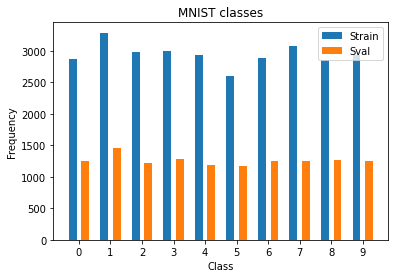

In [ ]:
# check for stratification in Strain and Sval
unique_t, counts_t = np.unique(y_Strain, return_counts=True)
unique_v, counts_v = np.unique(y_Sval, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique_t - 0.2, counts_t, 0.25, label='Strain')
rects2 = ax.bar(unique_v + 0.2, counts_v, 0.25, label='Sval')
ax.legend()
ax.set_xticks(unique_t)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


Em seguida, inicia-se o processo de construção e análise dos três modelos propostos, a saber: Logistic Regression, Neural Network e SVM.

Declaração de bibliotecas:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import GridSearchCV
import pandas as pd


Definição de critério de escolha do melhor modelo:

Por decisão de projeto, adota-se o f1-score como parâmetro de otimização e avaliação de modelos, conforme as seguintes razões:
* Popularidade;
* Adequação ao problema de classificação;
* Conveniencia de ser um medidor de número único, operando dentro do intervalo [0, 1], sendo 1 o melhor caso;
* Por ser uma média harmônica entre Precision e Recall, traz o benefício de maximizar as detecções afirmativas TP e TN (True Positive e True Negative), porém de modo a minimizar de forma balanceada os falsos scores FP e FN (False Positive e False Negative).

Mais detalhes em:

https://en.wikipedia.org/wiki/F-score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

A função a seguir imprime a avaliação de desempenho de determinado modelo, com base em:
* Matriz de Confusão
* Classification report, incluindo precision, recall e f1 para cada classe
* f1-score global, o critério de avaliação escolhido

In [ ]:
def print_report(y_true, y_hat):
    cm = confusion_matrix(y_true, y_hat, labels = unique_t)
    print("\n", cm)
    
    cr = classification_report(y_true, y_hat, labels = unique_t, digits=3)
    print("\n", cr)
    
    f1 = f1_score(y_true, y_hat, labels = unique_t, average = "micro")
    print("f1-score: ", format(f1, ".3f"))
    
    return


**Treinamento de Modelos**

A seguir, cada um dos três modelos são treinados com Strain em duas etapas (parâmetros default e otimizados por grid de parâmetros), e posteriormente avaliados, conforme critério estabelecido, com Sval.

A adoção desta estratégia se dá pelos seguintes motivos:
* Para se ganhar familiaridade com as diversas funções do Scikit-Learn a serem utilizadas, eliminando-se a complexidade inicial de uso dos hiperparâmetros;
* Para se ter uma base de comparação com os modelos otimizados, estes com uso de hiperparâmetros, de modo que se observe a eficácia da otimização.

Deve-se notar que o resultado da otimização por grid também inclui impressão da combinação de melhores parâmetros encontrados durante o processo.

**2.1 Logistic Regression básico**

In [ ]:
logistic_regression = LogisticRegression(max_iter=400)
logistic_regression.fit(X_Strain, y_Strain)
y_hat_log = logistic_regression.predict(X_Sval)

print_report(y_Sval, y_hat_log)



 [[1203    0    8    3    1    8    9    4    6    3]
 [   1 1408   11    5    1    6    2    5   19    2]
 [   9   10 1072   21   18    8   22   29   29    7]
 [   5   13   45 1101    1   64    7   11   22   16]
 [   0   10    6    0 1070    1   15    4    4   79]
 [  17    9   10   43   14 1000   28    5   31   10]
 [  12    5   15    2   11   12 1185    1    5    1]
 [   6    9   15    5   27    1    0 1153    7   35]
 [  10   35   16   31    6   38   12    4 1090   30]
 [   3   10    3   15   59   10    1   55    6 1088]]

               precision    recall  f1-score   support

           0      0.950     0.966     0.958      1245
           1      0.933     0.964     0.948      1460
           2      0.893     0.875     0.884      1225
           3      0.898     0.857     0.877      1285
           4      0.886     0.900     0.893      1189
           5      0.871     0.857     0.864      1167
           6      0.925     0.949     0.937      1249
           7      0.907     0.91

**2.2 Logistic Regression otimizado**

A otimização, neste caso, é feita apenas através do parâmetro C, o qual controla o nível de regularização do modelo. Conforme compreensão deste aluno sobre a documentação do modelo, os demais parâmetros não pareceram ter influência direta sobre f1_score.

In [ ]:
parameters = {'C': [1.0, 0.5, 0.25]}
logistic_regression = LogisticRegression(max_iter=400)
clf = GridSearchCV(logistic_regression, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain, y_Strain)
y_hat_log = clf.predict(X_Sval)

print_report(y_Sval, y_hat_log)
print('best parameters: ', clf.best_params_)
df_log = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch



 [[1203    0    8    3    1    8    9    4    6    3]
 [   1 1408   11    5    1    6    2    5   19    2]
 [   9   10 1072   21   18    8   22   29   29    7]
 [   5   13   45 1101    1   64    7   11   22   16]
 [   0   10    6    0 1070    1   15    4    4   79]
 [  17    9   10   43   14 1000   28    5   31   10]
 [  12    5   15    2   11   12 1185    1    5    1]
 [   6    9   15    5   27    1    0 1153    7   35]
 [  10   35   16   31    6   38   12    4 1090   30]
 [   3   10    3   15   59   10    1   55    6 1088]]

               precision    recall  f1-score   support

           0      0.950     0.966     0.958      1245
           1      0.933     0.964     0.948      1460
           2      0.893     0.875     0.884      1225
           3      0.898     0.857     0.877      1285
           4      0.886     0.900     0.893      1189
           5      0.871     0.857     0.864      1167
           6      0.925     0.949     0.937      1249
           7      0.907     0.91

**2.3 Neural Network básica**

In [ ]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_Strain, y_Strain)
y_hat_mlp = mlp_classifier.predict(X_Sval)

print_report(y_Sval, y_hat_mlp)



 [[1219    1    2    2    1    1    9    1    3    6]
 [   1 1432   12    0    1    2    3    5    4    0]
 [   1    4 1185    8    3    0    6   10    5    3]
 [   1    3   12 1218    1   15    1    6   18   10]
 [   1    2    4    1 1140    4    7    4    4   22]
 [   6    2    2   24    3 1110   10    3    1    6]
 [   7    3    2    2    0    9 1221    1    4    0]
 [   3    3    2    7    7    3    0 1224    1    8]
 [   2   15    7   10    5   11    7    0 1202   13]
 [   0    1    1   11   13    8    0   17   12 1187]]

               precision    recall  f1-score   support

           0      0.982     0.979     0.981      1245
           1      0.977     0.981     0.979      1460
           2      0.964     0.967     0.966      1225
           3      0.949     0.948     0.949      1285
           4      0.971     0.959     0.965      1189
           5      0.954     0.951     0.953      1167
           6      0.966     0.978     0.972      1249
           7      0.963     0.97

**2.4 Neural Network otimizada**

Para este modelo, quatro parâmetros foram escolhidos para varredura em grid: número de camadas escondidas do modelo, a função de ativação da rede, a estratégia de cálculo e a taxa de aprendizado. Com exceção do número de camadas escondidas, os demais parâmetros foram limitados em duas opções, de modo a evitar longos tempos de execução para o processo.

In [ ]:
parameters = {'hidden_layer_sizes': [80, 100, 120],
              'activation': ['tanh', 'relu'],
              'solver': ['lbfgs', 'adam'],
              'learning_rate': ['constant', 'adaptive']}
mlp_classifier = MLPClassifier(max_iter=400)
clf = GridSearchCV(mlp_classifier, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain, y_Strain)
y_hat_mlp = clf.predict(X_Sval)

print_report(y_Sval, y_hat_mlp)
print('best parameters: ', clf.best_params_)
df_mlp = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch



 [[1219    2    3    1    0    3    9    4    1    3]
 [   1 1433   12    2    0    2    2    7    1    0]
 [   3    3 1180    8    4    0    3   10   12    2]
 [   0    3    9 1232    0   14    1    6    8   12]
 [   0    1    1    0 1156    2    8    2    3   16]
 [   7    1    3   10    2 1126    9    1    3    5]
 [   9    2    6    0    1    9 1215    3    4    0]
 [   4    3    3    2    8    2    0 1225    1   10]
 [   2   15    7    6    9   15    5    3 1200   10]
 [   1    2    0   10   13    5    0   13    6 1200]]

               precision    recall  f1-score   support

           0      0.978     0.979     0.979      1245
           1      0.978     0.982     0.980      1460
           2      0.964     0.963     0.964      1225
           3      0.969     0.959     0.964      1285
           4      0.969     0.972     0.971      1189
           5      0.956     0.965     0.960      1167
           6      0.970     0.973     0.972      1249
           7      0.962     0.97

**PCA para SVM**

Como preparação para determinar o número de componentes (n_components) a ser utilizado de fato durante o Principal Component Análise, executa-se o código a seguir para:
* Verificar o percentual de colaboração de cada componente com a variância total dos dados;
* Definir n_components como o número de componentes que contribui com até 95% do total da variância.

In [ ]:
# returns the number of elements where its cumulative variance accounts
# for up to 95% of the total variance
def n_components_pca(v):
    v = -np.sort(-v)
    v = np.cumsum(v)
    v = v <= 0.95
    n = np.sum(v)
    
    return n

# optipmizing pca
pca = PCA(svd_solver='randomized', whiten=True)
pca = pca.fit(X_Strain)
n_pca = n_components_pca(pca.explained_variance_ratio_)
print("n_components definido como: ", n_pca)

# final pca
pca = PCA(n_components = n_pca, svd_solver='randomized', whiten=True)
pca = pca.fit(X_Strain)
X_Strain_pca = pca.transform(X_Strain)
X_Sval_pca = pca.transform(X_Sval)


n_components definido como:  74


**2.5 SVM básico**

In [ ]:
svm_classifier = SVC()
svm_classifier = svm_classifier.fit(X_Strain_pca, y_Strain)
y_hat_svm = svm_classifier.predict(X_Sval_pca)

print_report(y_Sval, y_hat_svm)



 [[1233    1    4    0    0    0    2    2    2    1]
 [   0 1441    7    1    1    2    1    5    2    0]
 [   2    5 1175    5    5    4    4   12   13    0]
 [   1    3   15 1227    1   16    0    7    8    7]
 [   0    4    3    0 1140    1    6    4    3   28]
 [   5    1    3   17    3 1121   12    1    4    0]
 [   9    3    1    1    1    6 1222    0    6    0]
 [   2    3    4    1   12    0    0 1223    3   10]
 [   0   14    6    8    6   14    4    0 1211    9]
 [   1    2    1   17   19    4    0   14    3 1189]]

               precision    recall  f1-score   support

           0      0.984     0.990     0.987      1245
           1      0.976     0.987     0.981      1460
           2      0.964     0.959     0.962      1225
           3      0.961     0.955     0.958      1285
           4      0.960     0.959     0.959      1189
           5      0.960     0.961     0.960      1167
           6      0.977     0.978     0.978      1249
           7      0.965     0.97

**2.6 SVM otimizado**

Para este modelo, três parâmetros são escolhidos: regularização, kernel do algoritmo, e coeficiente do kernel. Novamente, para fins de exercício e limitação de tempo de cálculo, as opções para cada parâmetro foram limitadas.

In [ ]:
parameters = {'C': [1.0, 0.5, 0.25],
              'kernel': ['rbf', 'sigmoid'],
              'gamma': ['scale', 'auto']}
svm_classifier = SVC()
clf = GridSearchCV(svm_classifier, parameters, scoring='f1_micro')
clf = clf.fit(X_Strain_pca, y_Strain)
y_hat_svm = clf.predict(X_Sval_pca)

print_report(y_Sval, y_hat_svm)
print('best parameters: ', clf.best_params_)
df_svm = pd.DataFrame(clf.cv_results_)   # usar para debug do gridsearch



 [[1233    1    4    0    0    0    2    2    2    1]
 [   0 1441    7    1    1    2    1    5    2    0]
 [   2    5 1175    5    5    4    4   12   13    0]
 [   1    3   15 1227    1   16    0    7    8    7]
 [   0    4    3    0 1140    1    6    4    3   28]
 [   5    1    3   17    3 1121   12    1    4    0]
 [   9    3    1    1    1    6 1222    0    6    0]
 [   2    3    4    1   12    0    0 1223    3   10]
 [   0   14    6    8    6   14    4    0 1211    9]
 [   1    2    1   17   19    4    0   14    3 1189]]

               precision    recall  f1-score   support

           0      0.984     0.990     0.987      1245
           1      0.976     0.987     0.981      1460
           2      0.964     0.959     0.962      1225
           3      0.961     0.955     0.958      1285
           4      0.960     0.959     0.959      1189
           5      0.960     0.961     0.960      1167
           6      0.977     0.978     0.978      1249
           7      0.965     0.97


**Conclusões:**

a. A otimização para a regressão logística resultou na obtenção do parâmetro C=1.0 default para o modelo. Como consequência, ambos os experimentos obtiveram resultado idêntico. Por uma questão de simplicidade, o modelo básico (apenas com parâmetros default) é escolhido.

f1-score = 0.902

b. A otimização para a rede neural resultou em um f1-score ligeiramente superior em relação aos parâmetros básicos. Neste caso, a versão otimizada abaixo é escolhida como melhor solução para o modelo:

{'activation': 'tanh',

 'hidden_layer_sizes': 120,

 'learning_rate': 'constant',

 'solver': 'adam'}

f1-score: 0.967

c. Por fim, para o SVM, a análise PCA identificou 74 elementos de entrada com contribuição de variância de 95% do total. O SVM básico obteve performance idêntica à rede neural otimizada. Já o SVM otimizado, para a varredura escolhida, não obteve melhoria em relação ao SVM básico. Por este motivo e por uma questão de simplicidade, a melhor solução é escolhida como sendo aquela com parâmetros default.

f1-score:  0.967


**3. Choosing a final model**

O código a seguir instancia e treina modelos utilizando Dtrain, conforme as otimizações escolhidas na seção anterior:

In [ ]:
logistic_regression = LogisticRegression(max_iter=400)
logistic_regression.fit(X_Dtrain, y_Dtrain)

mlp_classifier = MLPClassifier(activation='tanh',
                               hidden_layer_sizes= 120,
                               learning_rate='constant',
                               solver='adam')
mlp_classifier.fit(X_Dtrain, y_Dtrain)

pca = PCA(n_components = 74, svd_solver='randomized', whiten=True)
pca = pca.fit(X_Dtrain)
X_Dtrain_pca = pca.transform(X_Dtrain)
X_Dval_pca = pca.transform(X_Dval)
svm_classifier = SVC()
svm_classifier = svm_classifier.fit(X_Dtrain_pca, y_Dtrain)


Avaliando cada modelo com Dval, temos:

In [ ]:
y_hat_log = logistic_regression.predict(X_Dval)
y_hat_mlp = mlp_classifier.predict(X_Dval)
y_hat_svm = svm_classifier.predict(X_Dval_pca)

print_report(y_Dval, y_hat_log)
print_report(y_Dval, y_hat_mlp)
print_report(y_Dval, y_hat_svm)



 [[1724    1   11    5    8   18   16    5   16    1]
 [   1 1934   11   10    3   11    1    4   17    2]
 [   8   23 1563   25   20   10   28   33   42    7]
 [   8   10   45 1619    2   70    4   24   42   22]
 [   3    6   11    1 1606    3   14    9    9   64]
 [  20   16   20   61   16 1420   20   11   58   11]
 [  11    4   17    0   22   21 1694    3   14    1]
 [   7   18   30   10   21    3    0 1780    7   61]
 [  11   34   22   55   18   39   19    8 1499   25]
 [  12   10    3   22   63   12    0   53   16 1572]]

               precision    recall  f1-score   support

           0      0.955     0.955     0.955      1805
           1      0.941     0.970     0.955      1994
           2      0.902     0.889     0.895      1759
           3      0.895     0.877     0.886      1846
           4      0.903     0.930     0.916      1726
           5      0.884     0.859     0.871      1653
           6      0.943     0.948     0.946      1787
           7      0.922     0.91

**Conclusão:**

O modelo final escolhido com base na avaliação com Dval é o SVM, devido a vantagem bastante pequena do f1-score em relação à Neural Network, porém confirmando vantagem mínima igualmente observada na etapa anterior. Ambos demonstraram visível vantagem em relação ao modelo-base de Logistic Regression.

Todos os f1-scores obtidos nesta etapa preservam as ordens de grandeza observadas na etapa anterior.

f1-log: 0.912

f1-mlp: 0.970

f1-svm: 0.974

**4. Error estimation**

Relembrando os resultados da seção anterior, SVM foi escolhido por sua performance com base em modelo treinado com Dtrain e avaliado com Dval. Para comparação de desempenho, este mesmo modelo é avaliado com o test data original do Mnist.

Obs: Por questão de praticidade, Eout não é calculado diretamente. Em seu lugar, Precision e Recall são utilizados, já que indicam a quantidade de acertos de determinada predição. Sendo assim, Eout = (1 - precision) e/ou Eout = (1 - recall).

In [ ]:
X_test_pca = pca.transform(X_test)
y_hat_test = svm_classifier.predict(X_test_pca)
print_report(y_test, y_hat_test)


 [[ 974    0    1    0    0    0    2    1    1    1]
 [   0 1124    4    1    0    2    1    0    2    1]
 [   3    1 1002    2    2    1    2    6   13    0]
 [   0    0    7  984    0    4    1    5    6    3]
 [   1    0    5    0  964    0    2    0    1    9]
 [   3    2    1   13    1  862    4    0    6    0]
 [   5    4    1    0    3    4  939    0    2    0]
 [   0   12   18    2    2    1    0  985    2    6]
 [   2    1    3    8    3    5    2    3  946    1]
 [   6    1    2    6   10    7    0    7    2  968]]

               precision    recall  f1-score   support

           0      0.980     0.994     0.987       980
           1      0.982     0.990     0.986      1135
           2      0.960     0.971     0.965      1032
           3      0.969     0.974     0.971      1010
           4      0.979     0.982     0.980       982
           5      0.973     0.966     0.970       892
           6      0.985     0.980     0.983       958
           7      0.978     0.95

**Conclusão:**

Precision, recall e f1-score todos apresentaram valores consistentes e praticamente idênticos com a etapa anterior, o que parece indicar uma modelagem adequada. O Eout (= 1 - Recall) foi ligeiramente menor que o Ein, o que sugere denotar inexistência de overfitting.


Por fim, o SVM é treinado com a base de dados de treinamento do Mnist (= Dtrain + Dval), e avaliado com a base de dados de teste do Mnist:

In [ ]:
X_train_pca = pca.transform(X_train)
svm_classifier = svm_classifier.fit(X_train_pca, y_train)
y_hat_mnist = svm_classifier.predict(X_test_pca)
print_report(y_test, y_hat_mnist)



 [[ 973    0    1    0    0    0    2    1    2    1]
 [   0 1126    3    1    1    1    1    0    2    0]
 [   4    1 1001    1    3    1    2    8   10    1]
 [   2    0    3  989    0    3    0    4    6    3]
 [   1    0    4    0  966    0    2    0    1    8]
 [   2    1    1   10    0  870    4    0    3    1]
 [   5    4    1    0    4    2  939    0    3    0]
 [   1    9   14    2    2    1    0  994    2    3]
 [   3    0    3    6    2    5    2    3  948    2]
 [   6    1    2    6    9    8    0    7    2  968]]

               precision    recall  f1-score   support

           0      0.976     0.993     0.984       980
           1      0.986     0.992     0.989      1135
           2      0.969     0.970     0.969      1032
           3      0.974     0.979     0.977      1010
           4      0.979     0.984     0.981       982
           5      0.976     0.975     0.976       892
           6      0.986     0.980     0.983       958
           7      0.977     0.96

**Conclusão:**

Desta vez utilizando-se toda a base Mnist para treinamento e teste, precision, recall e f1-score apresentaram consistência com os experimentos anteriores. Nesta nova estimativa de Eout (= 1 - Recall), o valor encontrado foi ligeiramente menor que o Ein calculado nas seções anteriores, o que reforça a hipese de inexistência de overfitting.
